<a href="https://colab.research.google.com/github/mygfk/part_of_bangkit_assignment_5/blob/master/Fake_Job_Post_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Run on TensorFlow 2.0
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedKFold

In [0]:
print(tf.__version__)

1.15.2


Installing PyDrive to Access the Data from Google Drive. We can't use Github in this case because the filesize is more than 25 MB.

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1ZVE012JJ2nusDk706Ry7-EWHn9gi53Ui'}) 
downloaded.GetContentFile('fake_job_postings.csv') 
df = pd.read_csv('fake_job_postings.csv')

In [0]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [0]:
# Get all true job post
positive = df[df['fraudulent'] == 0]
print('Positive Job Post：', len(positive))

# Get all fake job post
negative = df[df['fraudulent'] == 1]
print('Negative Job Post：', len(negative))

Positive Job Post： 17014
Negative Job Post： 866


In [0]:
# NaN Value in All Column. We don't have any NaN value in label.
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [0]:
df = df.drop('job_id', axis=1)

In [0]:
cols = ["title", "company_profile", "description", "requirements", "benefits"]
for c in cols:
    df[c] = df[c].fillna("")

def extract_features(df):    
    for c in cols:
        df[c+"_length"] = df[c].apply(lambda x : len(str(x)))
        df[c+"_wordcount"] = df[c].apply(lambda x : len(str(x.split())))

    
extract_features(df)

In [0]:
df['combined_text'] = df['company_profile'] + " " + df['description'] + " " + df['requirements'] + " " + df['benefits']

n_features = {
    "title" : 100,
    "combined_text" : 500
}

for c, n in n_features.items():
    tfidf = TfidfVectorizer(max_features=n, norm='l2', stop_words = 'english')
    tfidf.fit(df[c])
    tfidf_train = np.array(tfidf.transform(df[c]).toarray(), dtype=np.float16)

    for i in range(n_features[c]):
        df[c + '_tfidf_' + str(i)] = tfidf_train[:, i]

In [0]:
cat_cols = ["employment_type", "required_experience", "required_education", "industry", "function"]
for c in cat_cols:
    encoded = pd.get_dummies(df[c])
    df = pd.concat([df, encoded], axis=1)

In [0]:
drop_cols = ['title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'combined_text']
drop_cols += cat_cols
df = df.drop(drop_cols, axis = 1)
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,title_length,title_wordcount,company_profile_length,company_profile_wordcount,description_length,description_wordcount,requirements_length,requirements_wordcount,benefits_length,benefits_wordcount,title_tfidf_0,title_tfidf_1,title_tfidf_2,title_tfidf_3,title_tfidf_4,title_tfidf_5,title_tfidf_6,title_tfidf_7,title_tfidf_8,title_tfidf_9,title_tfidf_10,title_tfidf_11,title_tfidf_12,title_tfidf_13,title_tfidf_14,title_tfidf_15,title_tfidf_16,title_tfidf_17,title_tfidf_18,title_tfidf_19,title_tfidf_20,title_tfidf_21,title_tfidf_22,title_tfidf_23,title_tfidf_24,title_tfidf_25,...,Wine and Spirits,Wireless,Writing and Editing,Accounting/Auditing,Administrative,Advertising,Art/Creative,Business Analyst,Business Development,Consulting,Customer Service,Data Analyst,Design,Distribution,Education,Engineering,Finance,Financial Analyst,General Business,Health Care Provider,Human Resources,Information Technology,Legal,Management,Manufacturing,Marketing,Other,Product Management,Production,Project Management,Public Relations,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing
0,0,1,0,0,16,23,885,1309,905,1278,852,1198,0,2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,41,60,1286,1745,2077,3020,1433,2033,1292,1972,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,39,52,879,1302,355,506,1363,1856,0,2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,33,49,614,868,2600,3637,1429,1958,782,1074,0.0,0.0,0.0,0.707031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,1,1,0,19,29,1628,2250,1520,1939,757,1025,21,31,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
test_split = 0.2
train_split = 1 - test_split

# We will have 20% of all data for Testing, and 80% for Training)
train_data = df.sample(frac = train_split)
test_data = df.drop(train_data.index)

x_train_data = train_data.iloc[:,0:-1].fillna('')
y_train_data = train_data['fraudulent']
x_test_data = test_data.iloc[:,0:-1].fillna('')
y_test_data = test_data['fraudulent']

print('Train Data Feature Length：', len(x_train_data))
print('Train Data Label Length：', len(y_train_data))
print('Test Data Feature Length：', len(x_test_data))
print('Test Data Label Length：', len(y_test_data))

Train Data Feature Length： 14304
Train Data Label Length： 14304
Test Data Feature Length： 3576
Test Data Label Length： 3576


In [0]:
# Define the learning rate，batch_size, iter_num, etc.
learning_rate = 0.003
batch_size = 10
iter_num = 300
m, n = x_train_data.shape 

In [0]:
# Building model and declare variable that will be learned
# Because we have such n columns in our new dataframe, then we use the value to declare A
A = tf.Variable(tf.random.normal(shape=[n, 1]))
b = tf.Variable(tf.random.normal(shape=[1, 1]))
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [0]:
# Define placeholders for both the feature and label
data = tf.placeholder(dtype=tf.float32, shape=[None, n])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])

In [0]:
# Declare the model for learning
mod = tf.matmul(data, A) + b

In [0]:
# Declare loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=target))

In [0]:
# Define the optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate)

In [0]:
# Define the goal
goal = opt.minimize(loss)

In [0]:
# Define the accuracy (default threshold is 0.5)
prediction = tf.round(tf.sigmoid(mod))
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
accuracy = tf.reduce_mean(correct)

In [0]:
# Start training model
# Define the variable that stores the result
loss_trace = []
train_acc = []
test_acc = []

In [0]:
# training model
for epoch in range(iter_num):
    # Generate random batch index
    batch_index = np.random.choice(len(x_train_data), size=batch_size)
    batch_train_X = x_train_data.iloc[batch_index]
    batch_train_y = np.matrix(y_train_data.iloc[batch_index]).T
    sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
    temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: batch_train_y})
    temp_loss = sess.run(loss, feed_dict={data: x_train_data, target: np.matrix(y_train_data).T})
    # convert into a matrix, and the shape of the placeholder to correspond
    temp_train_acc = sess.run(accuracy, feed_dict={data: x_train_data, target: np.matrix(y_train_data).T})
    temp_test_acc = sess.run(accuracy, feed_dict={data: x_test_data, target: np.matrix(y_test_data).T})
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    # output
    # if (epoch + 1) % 300 == 0:
    print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))

epoch:    1 loss: 221.941360 train_acc: 0.950573 test_acc: 0.955817
epoch:    2 loss: 221.941360 train_acc: 0.950573 test_acc: 0.955817
epoch:    3 loss: 121.599899 train_acc: 0.950573 test_acc: 0.955817
epoch:    4 loss: 150.483490 train_acc: 0.819142 test_acc: 0.823266
epoch:    5 loss: 101.749947 train_acc: 0.950084 test_acc: 0.956096
epoch:    6 loss: 229.240982 train_acc: 0.802363 test_acc: 0.810123
epoch:    7 loss: 165.889542 train_acc: 0.950364 test_acc: 0.955817
epoch:    8 loss: 143.346542 train_acc: 0.950084 test_acc: 0.955817
epoch:    9 loss: 98.435883 train_acc: 0.951063 test_acc: 0.956376
epoch:   10 loss: 98.435883 train_acc: 0.951063 test_acc: 0.956376
epoch:   11 loss: 200.788254 train_acc: 0.815436 test_acc: 0.820470
epoch:   12 loss: 477.969513 train_acc: 0.950503 test_acc: 0.955817
epoch:   13 loss: 477.969513 train_acc: 0.950503 test_acc: 0.955817
epoch:   14 loss: 393.256500 train_acc: 0.950573 test_acc: 0.955817
epoch:   15 loss: 393.256500 train_acc: 0.950573 t

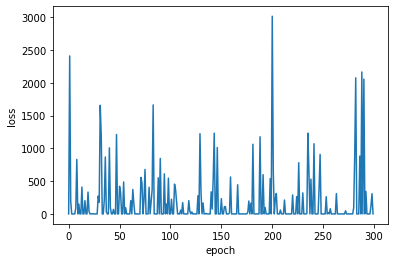

In [0]:
# Visualization of the results
plt.plot(loss_trace)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

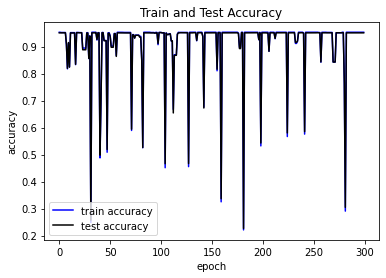

In [0]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

In [0]:
# There are n columns in the feature matrix 
# after One Hot Encoding. 
X = tf.placeholder(tf.float32, [None, n]) 
  
# Since this is a binary classification problem, 
# Y can take only 2 values. 
Y = tf.placeholder(tf.float32, [None, 1]) 
  
# Trainable Variable Weights 
W = tf.Variable(tf.zeros([n, 1])) 
  
# Trainable Variable Bias 
b = tf.Variable(tf.zeros([1]))

In [0]:
# Hypothesis 
Y_hat = tf.nn.sigmoid(tf.add(tf.matmul(X, W), b)) 
  
# Sigmoid Cross Entropy Cost Function 
cost = tf.nn.sigmoid_cross_entropy_with_logits( 
                    logits = Y_hat, labels = Y) 
  
# Gradient Descent Optimizer 
optimizer = tf.train.GradientDescentOptimizer( 
         learning_rate = alpha).minimize(cost) 
  
# Global Variables Initializer 
init = tf.global_variables_initializer() 

In [0]:
# Starting the Tensorflow Session 
with tf.Session() as sess: 
	
	# Initializing the Variables 
	sess.run(init) 
	
	# Lists for storing the changing Cost and Accuracy in every Epoch 
	cost_history, accuracy_history = [], [] 
	
	# Iterating through all the epochs 
	for epoch in range(epochs): 
		cost_per_epoch = 0
		
		# Running the Optimizer 
		sess.run(optimizer, feed_dict = {X : x_train_data, Y : np.matrix(y_train_data).T}) 
		
		# Calculating cost on current Epoch 
		c = sess.run(cost, feed_dict = {X : x_train_data, Y : np.matrix(y_train_data).T}) 
		
		# Calculating accuracy on current Epoch 
		correct_prediction = tf.equal(tf.argmax(Y_hat, 1), 
										tf.argmax(Y, 1)) 
		accuracy = tf.reduce_mean(tf.cast(correct_prediction, 
												tf.float32)) 
		
		# Storing Cost and Accuracy to the history 
		cost_history.append(sum(sum(c))) 
		accuracy_history.append(accuracy.eval({X : x_test_data, Y : np.matrix(y_test_data).T}) * 100) 
		
		# Displaying result on current Epoch 
		if epoch % 100 == 0 and epoch != 0: 
			print("Epoch " + str(epoch) + " Cost: "
							+ str(cost_history[-1])) 
	
	Weight = sess.run(W) # Optimized Weight 
	Bias = sess.run(b) # Optimized Bias 
	
	# Final Accuracy 
	correct_prediction = tf.equal(tf.argmax(Y_hat, 1), 
									tf.argmax(Y, 1)) 
	accuracy = tf.reduce_mean(tf.cast(correct_prediction, 
											tf.float32)) 
	print("\nAccuracy:", accuracy_history[-1], "%") 
